The fake news project by Noah Wenneberg Junge, Kevin Mark Lock and Marcus Friis-Hansen

# Introduction

This is our code for the fake news project. We have tried to keep as much as we could, though a small portion of specific values and small test of irrelevant classifier models and code have been lost due to editing the values/parameters or deleting/not saving it properly.

We have tried to structure the document as the project linearly and also saving as many of the models and we made.

Node that this document can be, but is not meant to be run all at once, and will probably result in a memory error. We made sure to run small portions of the code at a time and save the results for future loading. In the "Setting Up" section are all the imports and setting, to be able to run most of the sections by themselves.


# Setting Up


In [ ]:
DATA_PATH = "/content/drive/MyDrive/Data/"

## Imports

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
from nltk.corpus import stopwords
from nltk.stem import *
from nltk.stem.porter import *

import pandas as pd
from pandas import value_counts

from tqdm.auto import tqdm
tqdm.pandas()

from dataclasses import dataclass
import  matplotlib.pyplot as plt

import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import confusion_matrix

import scipy.sparse as sp
from scipy.sparse import save_npz, load_npz

from sklearn.preprocessing import OneHotEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression


from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from sklearn.model_selection import train_test_split

from sklearn.neural_network import MLPClassifier

from gensim.models import Word2Vec, KeyedVectors

import joblib

from scipy.sparse import csr_matrix, hstack, vstack

import re

## Grouping labels


In [ ]:
fakes = ['unreliable', 'fake', 'conspiracy', 'bias','junksci', 'satire','state']
reliables = ["reliable", "political", "clickbait", 'caution', 'hate']

# Part 1: Data Processing


### Task 1: Cleaning Functions and testing on News Sample

Cleaning functions:

In [ ]:
stop_words = set(stopwords.words("english"))


urlEx = re.compile(r'https?://\S+|www\.\S+')
emailEx = re.compile(r'\\b[\\w.-]+?@\\w+?\\.\\w{2,4}\\b')
numberEx = re.compile(r'[0-9]+\.?[0-9]+(th)?')
dateEx = re.compile(r'\\b[0-9]{4}-?[0-9]{2}-?[0-9]{2}\\b')
englishGrammarEx = re.compile(r'\'(\w+)\b')
nonCharEx = re.compile(r'[^<>a-zA-ZÀ-ž\-]')
spacesEx = re.compile(r'[\n\s]+')

stemmer = PorterStemmer()

#Tokenize text
def tokenize(txt):
    txt = str(txt) if txt is not None else ""
    #tokenize
    txt = txt.lower()
    txt = urlEx.sub(' <URL> ', txt) # Replace URL
    txt = emailEx.sub(' <EMAIL> ', txt) # Replace email
    txt = numberEx.sub(' <NUM> ', txt) # Replace number
    txt = dateEx.sub(' <DATE> ', txt) # Replace Date
    txt = englishGrammarEx.sub (" ", txt)# Replace dumb english grammar
    txt = nonCharEx.sub ( " ", txt) # Replace Any non character remaining
    txt = spacesEx.sub ( " ", txt) # Replace Newline and double space


    word_tokens = txt.split()

    return word_tokens

#Remove stopwords
def stopWordRemove(word_tokens):
    #remove stop words
    noStopWords = [i for i in word_tokens if not (i in stop_words)]
    return noStopWords

#Stem
def stem(word_tokens):
    #stemming
    singles = [stemmer.stem(w) for w in word_tokens]
    return singles

# Cleandata pipeline
def clean_data_pipeline(txt):
    txt = tokenize(txt)
    txt = stopWordRemove(txt)
    txt = stem(txt)
    return txt




Test on sample:

In [ ]:
news_sample = pd.read_csv(DATA_PATH + "news_sample.csv")
cleaned = news_sample["content"].progress_apply

### Task 2: Explore the FakeNewsCorpus

In [ ]:
################################################################## Retrieve small sample to explore
dataChunkToExplore = pd.read_csv(DATA_PATH + "995Data.csv", iterator=True).get_chunk(50000)
#dataChunkToExplore = pd.read_csv("0.5Data.csv") #for testing

In [ ]:
#Apply pipline to data sample
dataChunkToExplore["tokenized"] = dataChunkToExplore["content"].progress_apply(tokenize)

  0%|          | 0/50000 [00:00<?, ?it/s]

In [ ]:
dataChunkToExplore["cleaned"] = dataChunkToExplore["content"].progress_apply(clean_data_pipeline)
dataChunkToExplore = dataChunkToExplore[dataChunkToExplore['type'].isin(reliables)|dataChunkToExplore['type'].isin(fakes)]#remove rows with missing values or 'unknown'-label

Some useful functions:

In [ ]:
#Make vocabluary
def computeUniqueWords(column):
    flattened = [i for row in column for i in row]
    return pd.DataFrame(flattened).value_counts()

#plotting function
def plot(x, y, title, xLabel = "Category", yLabel = "Count"):
    # Create a bar chart
    plt.figure(figsize=(15, 6))
    plt.bar(x, y)
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)
    plt.title(title)
    plt.xticks(rotation=90)  # Rotate x-axis labels for readability
    plt.tight_layout()
    plt.show()

def plotRangeWords(data : pd.DataFrame, columnName, customTxt = "", range=[0, 100]):

    df = pd.DataFrame(computeUniqueWords(data[columnName]))
    df.columns = ["count"]
    df = df.sort_values("count", ascending=False)
    df = df.reset_index(names=["Category"])
    # Get the top 100 counts

    top_in_range = df.iloc[range[0]:range[1]]  # Assuming you have more than 100 counts
    sum = df["count"].sum()
    top_in_range.loc[:, "count"] = top_in_range["count"].apply(lambda x: x/sum)

    plot(top_in_range["Category"],top_in_range['count'], f'Top {range[0]} - {range[1]} Counts for ' + str(columnName)+ f" ({customTxt})" )



<ipython-input-132-6b5bfb7c2281>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_in_range.loc[:, "count"] = top_in_range["count"].apply(lambda x: x/sum)


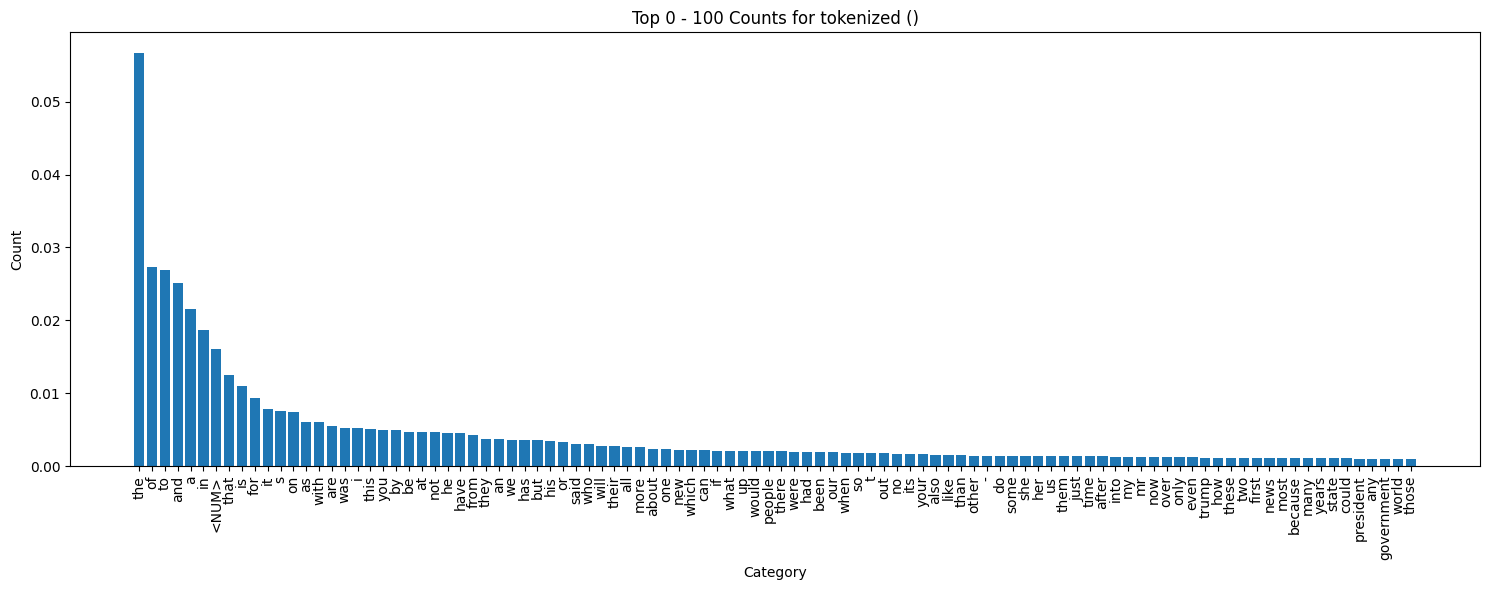

<ipython-input-132-6b5bfb7c2281>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_in_range.loc[:, "count"] = top_in_range["count"].apply(lambda x: x/sum)


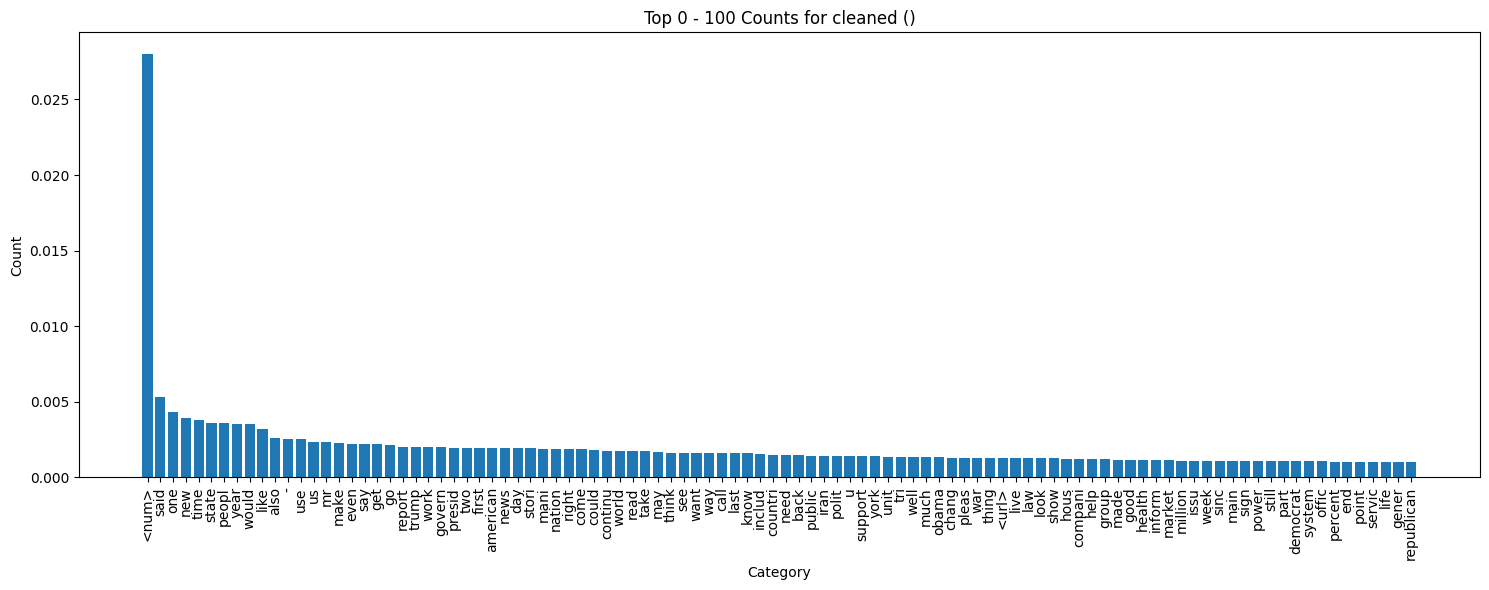

<ipython-input-132-6b5bfb7c2281>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_in_range.loc[:, "count"] = top_in_range["count"].apply(lambda x: x/sum)


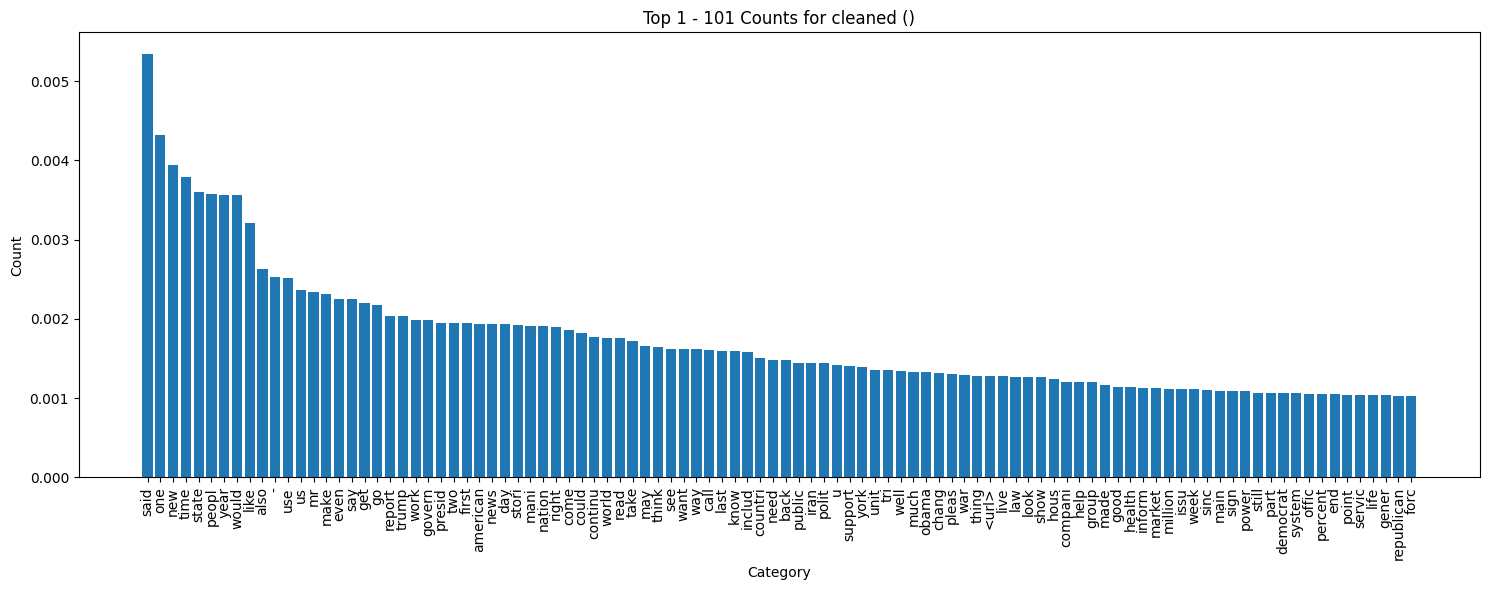

Number of links in all documents: 	15279
Number of dates in all documents: 	0
Number of numbers in all documents: 	334718


In [ ]:
plotRangeWords(dataChunkToExplore, "tokenized", range=[0, 100])
plotRangeWords(dataChunkToExplore, "cleaned", range=[0, 100])
plotRangeWords(dataChunkToExplore, "cleaned", range=[1, 101])

tokenizedValues = computeUniqueWords(dataChunkToExplore["tokenized"])
links = tokenizedValues["<URL>"] if "<URL>" in tokenizedValues.index else 0
dates = tokenizedValues["<DATE>"] if "<DATE>" in tokenizedValues.index else 0
nums = tokenizedValues["<NUM>"] if "<NUM>" in tokenizedValues.index else 0

print(f'Number of links in all documents: \t{links}')
print(f'Number of dates in all documents: \t{dates}')
print(f'Number of numbers in all documents: \t{nums}')

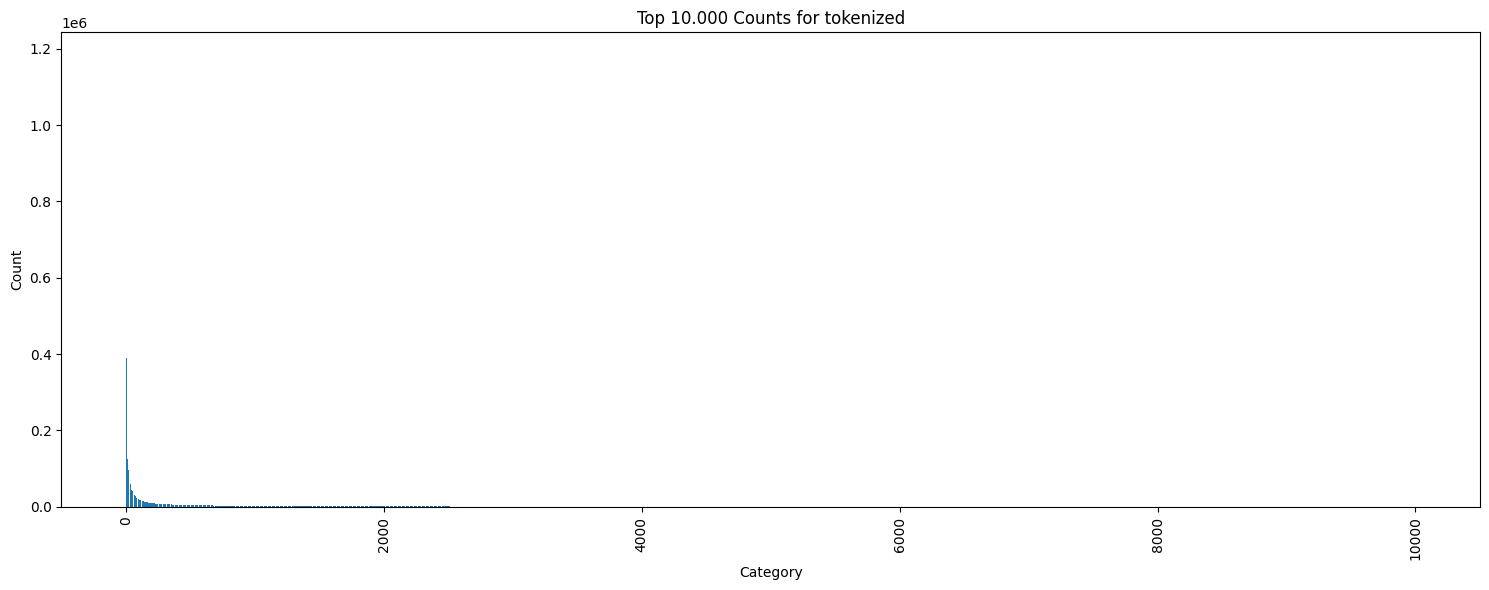

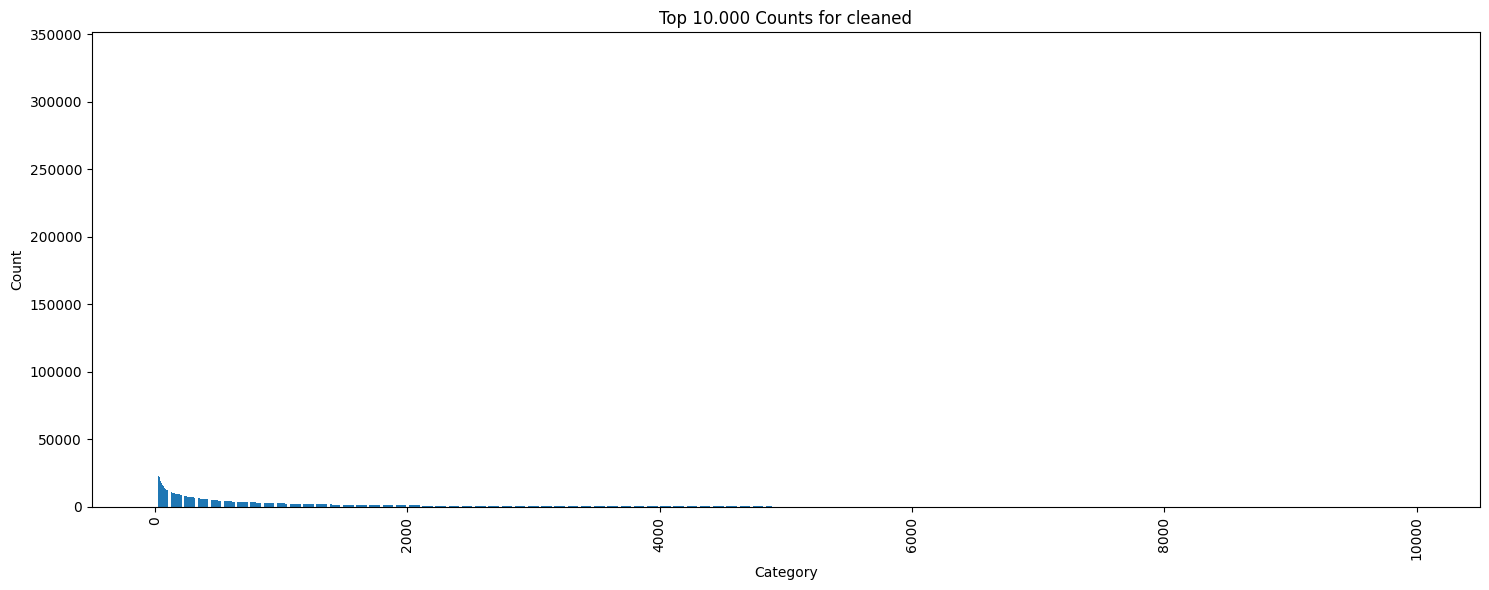

In [ ]:
import matplotlib.pyplot as plt
def plotTop10000Words(data, columnName):
    df = pd.DataFrame(computeUniqueWords(data[columnName]))
    df.columns = ["count"]
    df = df.sort_values("count", ascending=False)
    df = df.reset_index(names=["Category"])
    # Get the top 100 counts
    top_10000_df = df.head(10000)  # Assuming you have more than 100 counts

    plot (range(1, len(top_10000_df) + 1), top_10000_df['count'], 'Top 10.000 Counts for ' + str(columnName))

plotTop10000Words(dataChunkToExplore, "tokenized")
plotTop10000Words(dataChunkToExplore, "cleaned")

<ipython-input-132-6b5bfb7c2281>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_in_range.loc[:, "count"] = top_in_range["count"].apply(lambda x: x/sum)


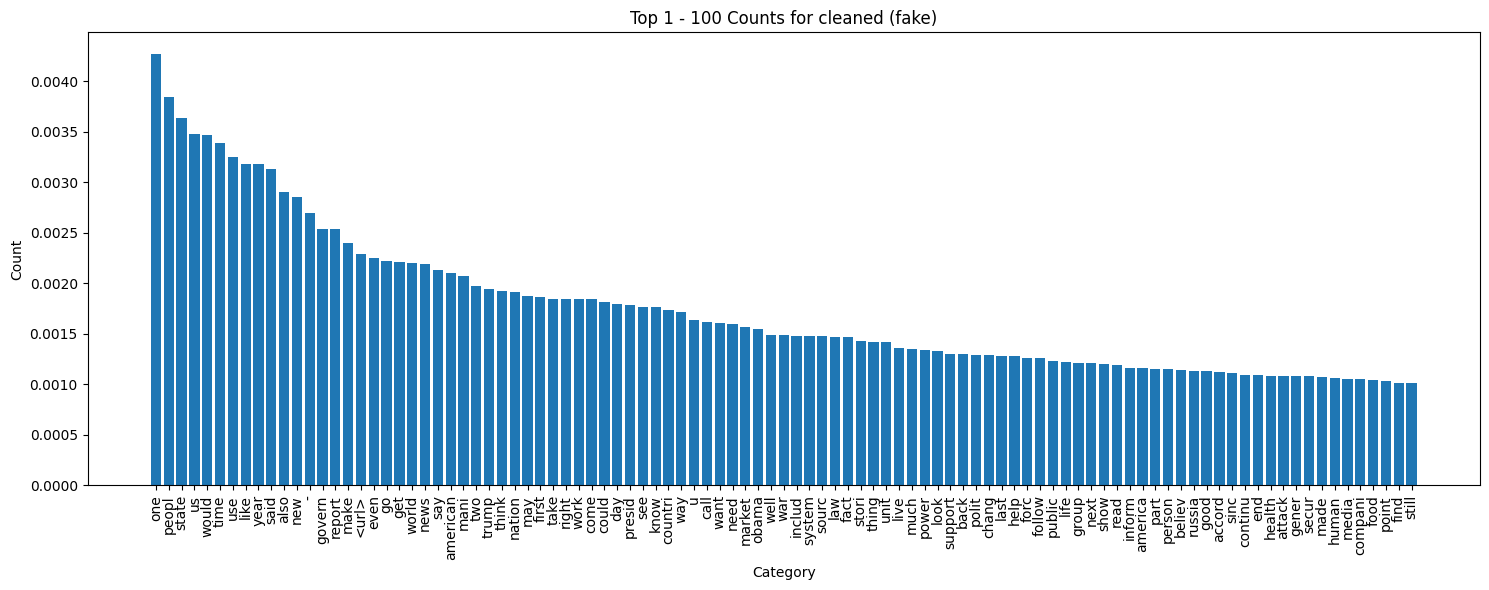

<ipython-input-132-6b5bfb7c2281>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_in_range.loc[:, "count"] = top_in_range["count"].apply(lambda x: x/sum)


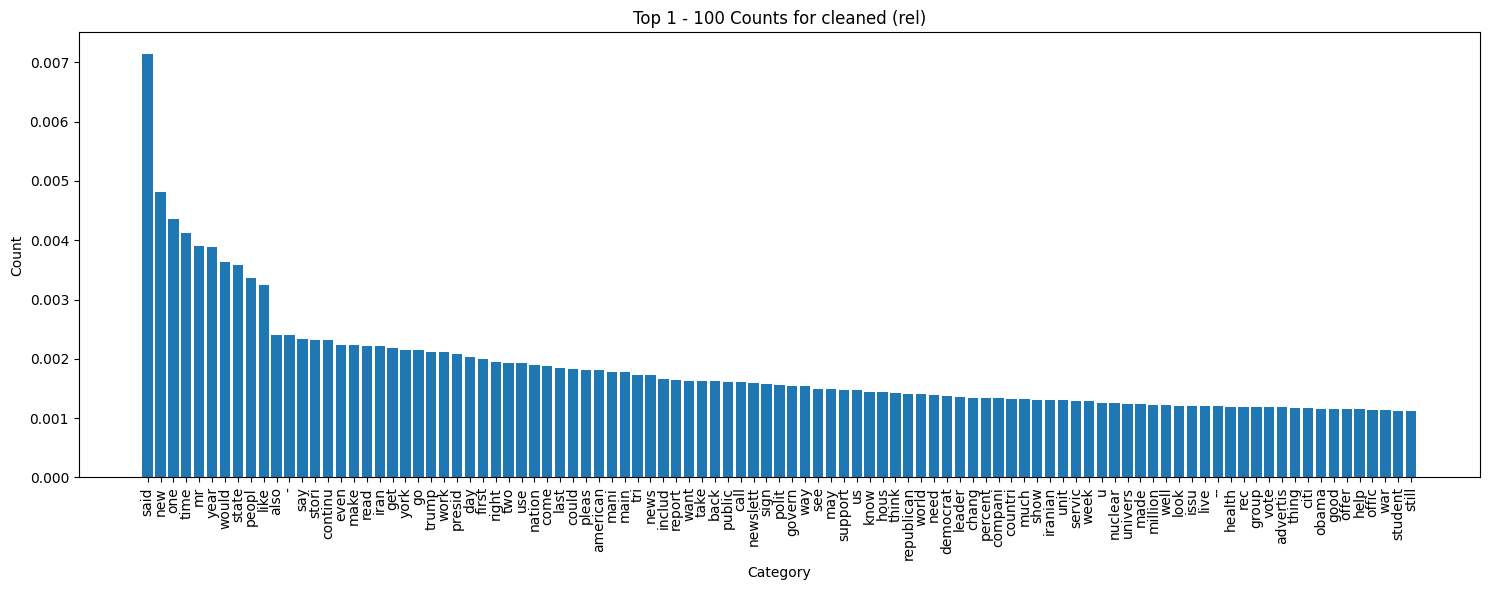

<ipython-input-132-6b5bfb7c2281>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_in_range.loc[:, "count"] = top_in_range["count"].apply(lambda x: x/sum)


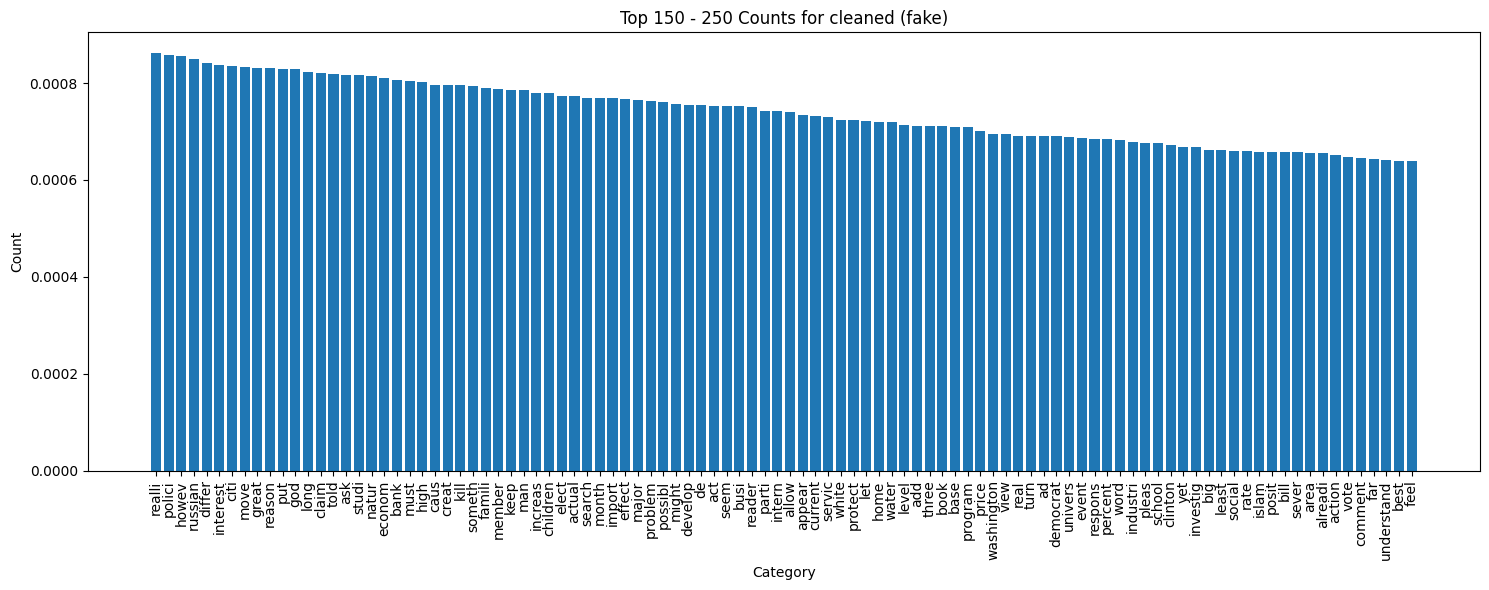

<ipython-input-132-6b5bfb7c2281>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_in_range.loc[:, "count"] = top_in_range["count"].apply(lambda x: x/sum)


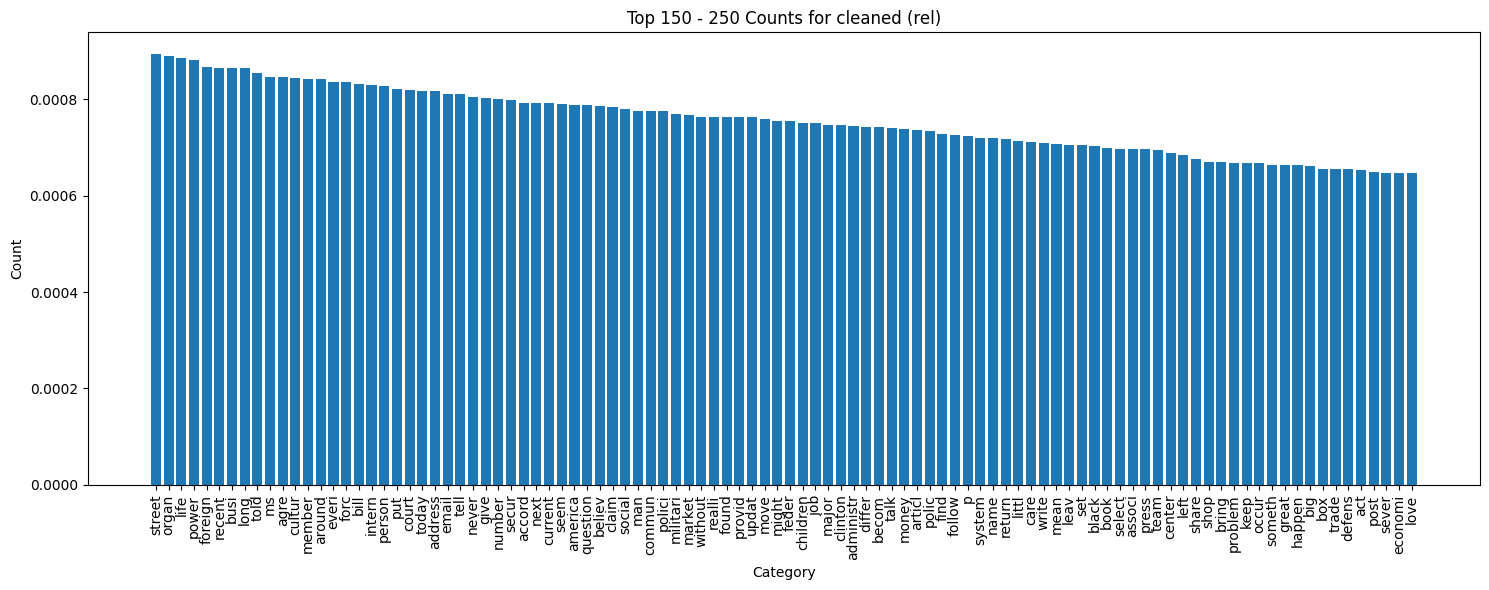

In [ ]:


fakeData = dataChunkToExplore[dataChunkToExplore["type"].isin(fakes)]
relData = dataChunkToExplore[dataChunkToExplore["type"].isin(reliables)]
plotRangeWords(fakeData, "cleaned", customTxt="fake", range=[1, 100])
plotRangeWords(relData, "cleaned", customTxt="rel", range=[1, 100])
plotRangeWords(fakeData, "cleaned", customTxt="fake", range=[150, 250])
plotRangeWords(relData, "cleaned", customTxt="rel", range=[150, 250])


In [ ]:

# make value counts
fakeValueCounts = pd.DataFrame(computeUniqueWords(fakeData["cleaned"]))
fakeValueCounts.columns = ["count"]
fakeValueCounts = fakeValueCounts.sort_values("count", ascending=False)

relValueCounts = pd.DataFrame(computeUniqueWords(relData["cleaned"]))
relValueCounts.columns = ["count"]
relValueCounts = relValueCounts.sort_values("count", ascending=False)

datachunkValueCounts = pd.DataFrame(computeUniqueWords(dataChunkToExplore["cleaned"]))
datachunkValueCounts.columns = ["count"]
datachunkValueCounts = datachunkValueCounts.sort_values("count", ascending=False)

# range to use (if range is [0, 500] it takes the top  500 words for fake plus the top 500 words for rel and conbines them, making)
rangeUsed = [0, 500]
data_range = pd.concat([fakeValueCounts.iloc[rangeUsed[0]:rangeUsed[1]], relValueCounts.iloc[rangeUsed[0]:rangeUsed[1]] ] )
data_range = data_range.reset_index()
data_range.columns = ["word", "count"]
data_range = pd.DataFrame(data_range.groupby('word', as_index=False)['count'].sum())
data_range = data_range.sort_values("count", ascending=False)
data_range = data_range.set_index("word")


# Since data_range is combined from two valueCount dataframes, there might be overlap between the words used. Chatgpt fix it here:


differenceFrame = pd.DataFrame(columns = ["word", "diff", "absDiff"])
for i in range(0, len(data_range)):
    # Get the word

    word = str(data_range.index[i])

    # find count for each
    fakeWordCount = fakeValueCounts.loc[word]["count"][0] if word in fakeValueCounts.index else 0
    relWordCount = relValueCounts.loc[word]["count"][0] if word in relValueCounts.index else 0

    # find difference in frequency and append it
    difference = (1+relWordCount/relValueCounts.sum())/(1+fakeWordCount/fakeValueCounts.sum())
    logDiff = np.log(float(difference)) # red line but works in runtime. Pylance cannot see it is a float in advance
    newRow = pd.DataFrame({"word" : [word], "diff": [logDiff], "absDiff" : [abs(logDiff)]})
    differenceFrame = pd.concat([differenceFrame, newRow])


def plotDifferenceFrame(topN, frame, title):
    topNFrame = differenceFrame.head(topN)
    plot(topNFrame["word"], topNFrame["diff"], title, xLabel="Word", yLabel="log(relCount / fakeCount)")





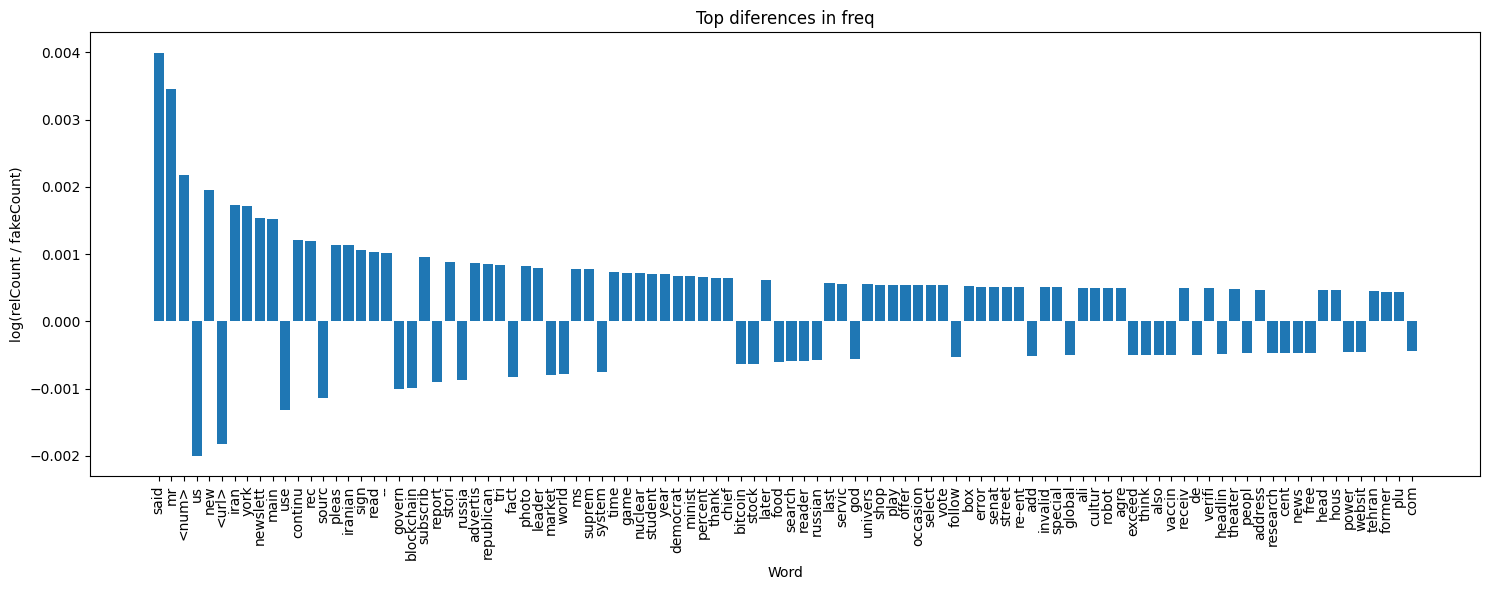

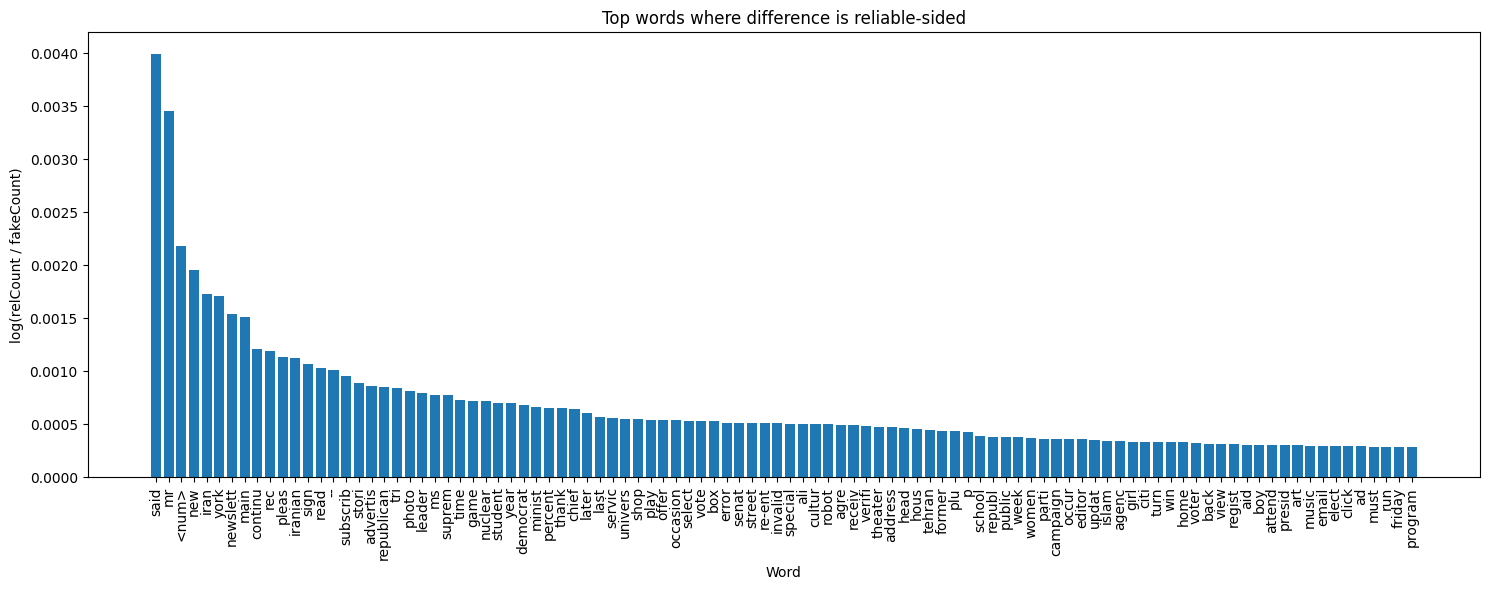

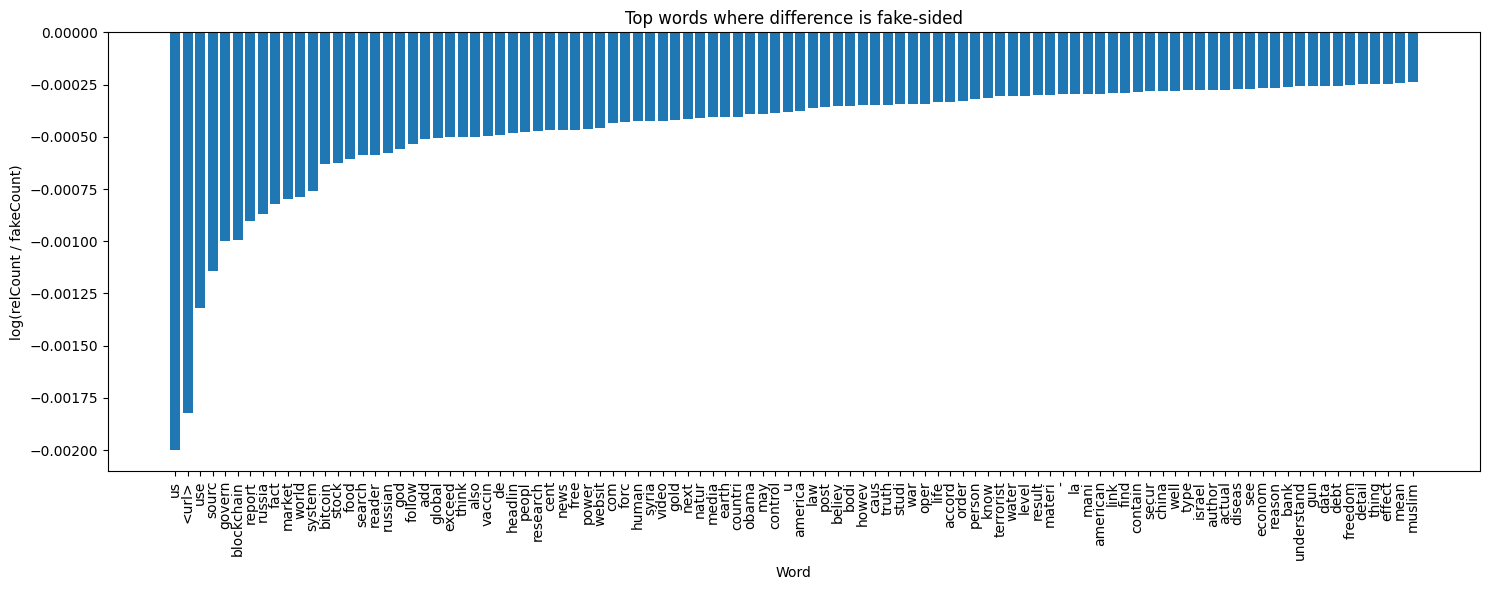

In [ ]:
#Now we can make the graphs. We have decided to make 3 different graphs to see three different patters:
differenceFrame = differenceFrame.sort_values("absDiff", ascending = False)
plotDifferenceFrame(100, differenceFrame, "Top diferences in freq")

differenceFrame = differenceFrame.sort_values("diff", ascending = False)
plotDifferenceFrame(100, differenceFrame, "Top words where difference is reliable-sided")

differenceFrame = differenceFrame.sort_values("diff", ascending = True)
plotDifferenceFrame(100, differenceFrame.sort_values("diff", ascending = True), "Top words where difference is fake-sided")

When looking at the top words in these graphs there are some clear patterns. Reliable articles tend to use more words that points to a source like "mr", "said", "newsletter" etc and talking about stuff. They talk about stuff, that is happening without using strongly emotional words. They use words like "court, iran, student, children" etc, that are not so emotional. Also, reliable articles use far more numbers than fake ones, also tending to the pattern of having sources, statistics and outside knowledge.

Comparing to the top words that fake articles use are very exaturated like "nuclear", "parasite", "kill", "gun" etc. These are emotional words, that probably triggers emotions in people making them likely to react in certain ways.

There is a clear pattern in what words are used in each category.

Boksplot of length of articles

In [ ]:
################################################################## Retrieve small sample to explore
boks = pd.read_csv(DATA_PATH + "995Data.csv")
#dataChunkToExplore = pd.read_csv("0.5Data.csv") #for testing

In [ ]:
#Apply pipline to data sample
boks["tokenized"] = boks["content"].progress_apply(tokenize)

  0%|          | 0/995000 [00:00<?, ?it/s]

In [ ]:
boks = dataChunkToExplore

In [ ]:
boks["lengths"] = boks["tokenized"].progress_apply(lambda tokens : len(tokens))

  0%|          | 0/995000 [00:00<?, ?it/s]

<Axes: >

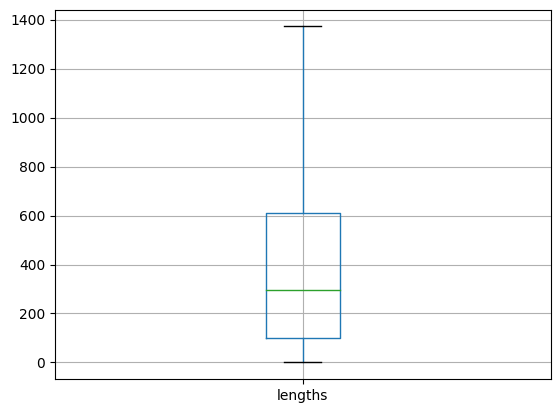

In [ ]:

# Create a boxplot for the 'lengths' column
boks.boxplot(column="lengths", showfliers=False)

### Task 3: Clean entire Data

In [ ]:
from tqdm import tqdm

chunksize = 500
dataChunk = pd.DataFrame(columns=["type", "cleaned"])
tqdm.pandas()
with tqdm(total=995000, desc="Cleaning Progress") as pbar:
  for i, chunk in enumerate(pd.read_csv(DATA_PATH + "995Data.csv", chunksize=chunksize, dtype=object)):
      new = pd.DataFrame(columns=["type", "cleaned"])
      new["type"] = chunk["type"]
      new['cleaned'] = chunk['content'].apply(clean_data_pipeline)

      # Save the cleaned chunk if needed
      dataChunk = pd.concat([dataChunk, new])
      pbar.update(chunksize)

try:
    dataChunk.to_parquet(DATA_PATH +"cleaned995DataReal.parquet")
    print("yes")
except:
    print("no")

In [ ]:
from tqdm import tqdm

chunksize = 500
dataChunk = pd.DataFrame(columns=["type", "cleaned", "domain"])
tqdm.pandas()
with tqdm(total=995000, desc="Cleaning Progress") as pbar:
  for i, chunk in enumerate(pd.read_csv(DATA_PATH +"995Data.csv", chunksize=chunksize, dtype=object)):
      new = pd.DataFrame(columns=["type", "cleaned"])
      new["type"] = chunk["type"]
      new["domain"] = chunk["domain"]
      new['cleaned'] = chunk['content'].apply(lambda txt : stopWordRemove(tokenize(txt)))

      # Save the cleaned chunk if needed
      dataChunk = pd.concat([dataChunk, new])
      pbar.update(chunksize)

try:
    dataChunk.to_parquet(DATA_PATH + "notStemmedWithDomain.parquet")
    print("yes")
except:
    print("no")



In [ ]:
data = pd.read_parquet(DATA_PATH +"cleaned995DataReal.parquet")

In [ ]:
data_notStemmed = pd.read_parquet(DATA_PATH +"notStemmedWithDomain.parquet")



In [ ]:
def grouping_rules(label):
    if label in fakes:
        return 1
    elif label in reliables:
        return 0
    else:
        raise Exception("Label is not in either fakes or reliables")


# This removes any row, that has a cleaned-list of length 5 or fewer.
# Then it removes any row with type that we are not taking into account eg. unknown, missing etc.
# Finaly applying grouping rule, making fake = 1 and reliable = 0
def removeAndGroupingRule(df):
  df = df[df['cleaned'].apply(lambda x: len(x) > 5)]
  df = df[df['type'].isin(reliables) | df['type'].isin(fakes)]
  df = df.reset_index(drop=True)
  df["type"] = df["type"].apply(grouping_rules)
  return df



In [ ]:
data = removeAndGroupingRule(data)
data_notStemmed = removeAndGroupingRule(data_notStemmed)
print(len(data))
print(len(data_notStemmed))

840760
840760


### Task 4 Split the data.


In [ ]:
X = np.array(data["cleaned"])

In [ ]:
X_notStemmed = np.array(data_notStemmed["cleaned"])

In [ ]:
domains = np.array(data_notStemmed["domain"])

In [ ]:
y = data["type"]

In [ ]:
#first split data into training(80%) and other(20%)
X_train, X_other, X_train_notStemmed, X_other_notStemmed, y_train, y_other, domains_train, domains_other = train_test_split(X, X_notStemmed, y, domains, random_state=0,test_size=0.20)

#second split to split other into validation(10%) and test(10%)
X_val, X_test, X_val_notStemmed, X_test_notStemmed, y_val, y_test, domains_val, domains_test = train_test_split(X_other, X_other_notStemmed, y_other, domains_other,  random_state= 0 , test_size= 0.50,)

In [ ]:

np.savez(
    DATA_PATH +'dataSplitted.npz',
    X_train=X_train,
    X_train_notStemmed=X_train_notStemmed,
    y_train=y_train,
    X_val=X_val,
    X_val_notStemmed=X_val_notStemmed,
    y_val=y_val,
    X_test=X_test,
    X_test_notStemmed=X_test_notStemmed,
    y_test=y_test
)

np.savez(
    DATA_PATH +'domains.npz',
    domains_train=domains_train,
    domains_val=domains_val,
    domains_test=domains_test,
)



# Part 2: Simple Model

## Make BoW vector

In [ ]:
dataSplitted = np.load(DATA_PATH +'dataSplitted.npz', allow_pickle=True)
X_train = dataSplitted["X_train"]
X_val = dataSplitted["X_val"]
X_test = dataSplitted["X_test"]

For our simple vector, we will use a simple BoW vector

In [ ]:
X_train_joined = np.array(pd.DataFrame(X_train)[0].progress_apply(lambda tokens: ' '.join(tokens)))
X_val_joined = np.array(pd.DataFrame(X_val)[0].progress_apply(lambda tokens: ' '.join(tokens)))
X_test_joined = np.array(pd.DataFrame(X_test)[0].progress_apply(lambda tokens: ' '.join(tokens)))

  0%|          | 0/672608 [00:00<?, ?it/s]

  0%|          | 0/84076 [00:00<?, ?it/s]

  0%|          | 0/84076 [00:00<?, ?it/s]

In [ ]:
vectorizer = CountVectorizer(min_df=0.01)

vectorizer.fit(X_train_joined)

bow_train = vectorizer.transform(X_train_joined)
bow_val = vectorizer.transform(X_val_joined)
bow_test = vectorizer.transform(X_test_joined)

In [ ]:
joblib.dump({
    'bow_vectorizer' : vectorizer,
    'bow_train': bow_train,
    'bow_val': bow_val,
    'bow_test': bow_test
}, DATA_PATH +'bow.joblib')


## Preprocessesing Scraped Articles

## Models

### Model 0: Forest classifier

In [ ]:
dataSplitted = np.load(DATA_PATH +'dataSplitted.npz', allow_pickle=True)
bow = joblib.load(DATA_PATH +"bow.joblib")

In [ ]:
X_train = bow["bow_train"]
X_val = bow["bow_val"]
X_test = bow["bow_test"]

y_train = dataSplitted["y_train"]
y_val = dataSplitted["y_val"]
y_test = dataSplitted["y_test"]

In [ ]:
model0_simple = RandomForestClassifier(max_depth=20, random_state=0)
model0_simple.fit(X_train[0: 40000], y_train[0:40000])

RandomForestClassifier(max_depth=20, random_state=0)

In [ ]:
#make prediction
y_pred = model0_simple.predict(X_val)
y_pred = np.rint(y_pred)



print("accuracy: ", accuracy_score(y_val, y_pred))
print("precision: ", precision_score(y_val, y_pred, average="binary"))
print("recall: ", recall_score(y_val, y_pred, average="binary"))
print("f1: ", f1_score(y_val, y_pred, average="binary"))

accuracy:  0.8176530757885723
precision:  0.7992185151788398
recall:  0.8135022818244397
f1:  0.8062971432903332


In [ ]:
joblib.dump(model0_simple, DATA_PATH +"model0_simple.joblib")

### Model 1: Linear Regression

In [ ]:
dataSplitted = np.load(DATA_PATH + 'dataSplitted.npz', allow_pickle=True)
bow = joblib.load(DATA_PATH + "bow.joblib")

In [ ]:
X_train = bow["bow_train"]
X_val = bow["bow_val"]
X_test = bow["bow_test"]

y_train = dataSplitted["y_train"]
y_val = dataSplitted["y_val"]
y_test = dataSplitted["y_test"]

In [ ]:
model1_simple = LinearRegression()
model1_simple.fit(X_train, y_train)

LinearRegression()

In [ ]:
#make prediction
y_pred = model1_simple.predict(X_val)
y_pred = np.clip(np.rint(y_pred), 0, 1)



print("accuracy: ", accuracy_score(y_val, y_pred))
print("precision: ", precision_score(y_val, y_pred, average="binary"))
print("recall: ", recall_score(y_val, y_pred, average="binary"))
print("f1: ", f1_score(y_val, y_pred, average="binary"))

accuracy:  0.8035467909986203
precision:  0.8242787774921451
recall:  0.7357417841572547
f1:  0.7774978783021029


In [ ]:
joblib.dump(model1_simple, DATA_PATH + "model1_simple.joblib")

### Model 2: Logistic Regression

In [ ]:
dataSplitted = np.load(DATA_PATH +'dataSplitted.npz', allow_pickle=True)
bow = joblib.load(DATA_PATH +"bow.joblib")

In [ ]:
X_train = bow["bow_train"]
X_val = bow["bow_val"]
X_test = bow["bow_test"]

y_train = dataSplitted["y_train"]
y_val = dataSplitted["y_val"]
y_test = dataSplitted["y_test"]

In [ ]:
model2_simple = LogisticRegression(max_iter=300, verbose=100)
model2_simple.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:  1.8min
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:  1.8min


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=300, verbose=100)

In [ ]:
#make prediction
y_pred = model2_simple.predict(X_val)
y_pred = np.rint(y_pred)

print("accuracy: ", accuracy_score(y_val, y_pred))
print("precision: ", precision_score(y_val, y_pred, average="binary"))
print("recall: ", recall_score(y_val, y_pred, average="binary"))
print("f1: ", f1_score(y_val, y_pred, average="binary"))

accuracy:  0.8315095865645369
precision:  0.8115224904890966
recall:  0.8320883155291539
f1:  0.8216767371601207


In [ ]:
joblib.dump(model2_simple, DATA_PATH +"model2_simple.joblib")

final test

In [ ]:
model2_simple = joblib.load(DATA_PATH + "model2_simple.joblib")

In [ ]:
#make prediction
y_pred = model2_simple.predict(X_test)
y_pred = np.rint(y_pred)

print("accuracy: ", accuracy_score(y_test, y_pred))
print("precision: ", precision_score(y_test, y_pred, average="binary"))
print("recall: ", recall_score(y_test, y_pred, average="binary"))
print("f1: ", f1_score(y_test, y_pred, average="binary"))

accuracy:  0.8305104905085875
precision:  0.8101246994074919
recall:  0.8321576816318216
f1:  0.820993392457855


### Model 3: Adding scraped Articles

In [ ]:
scraped = pd.read_csv("/content/drive/MyDrive/Data/BBC_scraped.csv")[["Content"]]

scraped.columns = ["content"]
scraped["type"] = 0
scraped["cleaned"] = scraped["content"].progress_apply(clean_data_pipeline)

  0%|          | 0/4795 [00:00<?, ?it/s]

In [ ]:
bow_vectorizer = joblib.load("/content/drive/MyDrive/Data/bow.joblib")["bow_vectorizer"]


In [ ]:
scraped_joined = np.array(scraped["cleaned"].progress_apply(lambda tokens: ' '.join(tokens)))

bow_scraped = bow_vectorizer.transform(scraped_joined)

  0%|          | 0/4795 [00:00<?, ?it/s]

In [ ]:
joblib.dump({"data" :  scraped, "bow" : bow_scraped}, "/content/drive/MyDrive/Data/scraped_cleaned.joblib")

['/content/drive/MyDrive/Data/scraped_cleaned.joblib']

In [ ]:
scraped = joblib.load("/content/drive/MyDrive/Data/scraped_cleaned.joblib")

In [ ]:
dataSplitted = np.load('/content/drive/MyDrive/Data/dataSplitted.npz', allow_pickle=True)
bow = joblib.load("/content/drive/MyDrive/Data/bow.joblib")

In [ ]:
X_train = vstack([bow["bow_train"], scraped["bow"]])
X_val = bow["bow_val"]
X_test = bow["bow_test"]


y_train = np.concatenate((dataSplitted["y_train"], scraped["data"]["type"]), axis = 0)
y_val = dataSplitted["y_val"]
y_test = dataSplitted["y_test"]

In [ ]:
model3_simple = LogisticRegression(max_iter=300, verbose=100)
model3_simple.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:  1.8min
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:  1.8min


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=300, verbose=100)

In [ ]:
#make prediction
y_pred = model3_simple.predict(X_val)
y_pred = np.rint(y_pred)

print("accuracy: ", accuracy_score(y_val, y_pred))
print("precision: ", precision_score(y_val, y_pred, average="binary"))
print("recall: ", recall_score(y_val, y_pred, average="binary"))
print("f1: ", f1_score(y_val, y_pred, average="binary"))

accuracy:  0.8312836005518817
precision:  0.8119455795873617
recall:  0.8307625627820412
f1:  0.8212462982798816


In [ ]:
joblib.dump(model3_simple, "/content/drive/MyDrive/Data/model3_simple.joblib")

['/content/drive/MyDrive/Data/model3_simple.joblib']

### Model 4: Adding domains

We have done this before so we just load it:

#### One hot encoding for domain

In [ ]:
domains = np.load('/content/drive/MyDrive/Data/domains.npz', allow_pickle=True)
bow = joblib.load("/content/drive/MyDrive/Data/bow.joblib")

In [ ]:
dataSplitted = np.load('/content/drive/MyDrive/Data/dataSplitted.npz', allow_pickle=True)

In [ ]:
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

doms_train = domains["domains_train"].reshape(-1, 1)
doms_val = domains["domains_val"].reshape(-1, 1)
doms_test = domains["domains_test"].reshape(-1, 1)




oheDomainFitted = ohe.fit(doms_train)


oh_train = np.array(oheDomainFitted.transform(doms_train))
oh_val = np.array(oheDomainFitted.transform(doms_val))
oh_test = np.array(oheDomainFitted.transform(doms_test))


In [ ]:

bow_train = bow["bow_train"]
bow_val = bow["bow_val"]
bow_test = bow["bow_test"]

y_train = dataSplitted["y_train"]
y_val = dataSplitted["y_val"]
y_test = dataSplitted["y_test"]

In [ ]:

# Combine the sparse matrices using hstack
X_train = hstack([bow_train, csr_matrix(oh_train)])
X_val = hstack([bow_val, csr_matrix(oh_val)])
X_test = hstack([bow_test, csr_matrix(oh_test)])

In [ ]:
model4_simple = LogisticRegression(max_iter=300, verbose=100)
model4_simple.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:  1.1min
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:  1.1min


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=300, verbose=100)

In [ ]:
#make prediction
y_pred = model4_simple.predict(X_val)


print("accuracy: ", accuracy_score(y_val, y_pred))
print("precision: ", precision_score(y_val, y_pred, average="binary"))
print("recall: ", recall_score(y_val, y_pred, average="binary"))
print("f1: ", f1_score(y_val, y_pred, average="binary"))

accuracy:  0.9982634759027547
precision:  0.9976060104418694
recall:  0.9986742472528873
f1:  0.9981398430333299


In [ ]:
joblib.dump(model4_simple, "/content/drive/MyDrive/Data/model4_simple.joblib")

['/content/drive/MyDrive/Data/model4_simple.joblib']

### Simple Models

Here we fit a few simple models on the data an compare what works and what doesnt

# Part 3: Advanced Model

## Make TFIDF Vector

In [ ]:
bow = joblib.load(DATA_PATH + "bow.joblib")

In [ ]:
bow_train = bow["bow_train"]
bow_val = bow["bow_val"]
bow_test = bow["bow_test"]

In [ ]:
vectorizer = TfidfTransformer()

# This ensures that the IDF values only come from X_train, and data from test and validation does not leak into train data.
vectorizer.fit(bow_train)

tfidf_train = vectorizer.transform(bow_train)
tfidf_val = vectorizer.transform(bow_val)
tfidf_test = vectorizer.transform(bow_test)


In [ ]:
joblib.dump({
    'tfidf_vectorizer' : vectorizer,
    'tfidf_train': tfidf_train,
    'tfidf_val': tfidf_val,
    'tfidf_test': tfidf_test
}, DATA_PATH + 'tfidf.joblib')

## Model 1: TFIDF Vector


In [ ]:
dataSplitted = np.load(DATA_PATH + 'dataSplitted.npz', allow_pickle=True)
tfidf = joblib.load(DATA_PATH + "tfidf.joblib")

In [ ]:
X_train = tfidf["tfidf_train"]
X_val = tfidf["tfidf_val"]
X_test = tfidf["tfidf_test"]

y_train = dataSplitted["y_train"]
y_val = dataSplitted["y_val"]
y_test = dataSplitted["y_test"]

In [ ]:
model1 = LogisticRegression(max_iter=300, verbose=100)

model1.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   52.6s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   52.6s


LogisticRegression(max_iter=300, verbose=100)

In [ ]:
#make prediction
y_pred = model1.predict(X_val)

print("accuracy: ", accuracy_score(y_val, y_pred))
print("precision: ", precision_score(y_val, y_pred, average="binary"))
print("recall: ", recall_score(y_val, y_pred, average="binary"))
print("f1: ", f1_score(y_val, y_pred, average="binary"))

accuracy:  0.8397759170274514
precision:  0.8313262312799136
recall:  0.8236748846340157
f1:  0.8274828712300698


Final F1 test (Only Used Once)

In [ ]:
#make prediction
y_pred = model1.predict(X_test)

print("accuracy: ", accuracy_score(y_test, y_pred))
print("precision: ", precision_score(y_test, y_pred, average="binary"))
print("recall: ", recall_score(y_test, y_pred, average="binary"))
print("f1: ", f1_score(y_test, y_pred, average="binary"))

accuracy:  0.8412626671107094
precision:  0.8328667916484758
recall:  0.825867732817235
f1:  0.8293524959083469


In [ ]:
joblib.dump(model1, DATA_PATH + "model1_advanced.joblib")

## Model 2: Simple Neural Network

In [ ]:
dataSplitted = np.load(DATA_PATH + 'dataSplitted.npz', allow_pickle=True)
tfidf = joblib.load(DATA_PATH + "tfidf.joblib")

In [ ]:
X_train = tfidf["tfidf_train"]
X_val = tfidf["tfidf_val"]
X_test = tfidf["tfidf_test"]

y_train = dataSplitted["y_train"]
y_val = dataSplitted["y_val"]
y_test = dataSplitted["y_test"]

In [ ]:
model2 = MLPClassifier(verbose=True, solver='adam', hidden_layer_sizes=(5, 5), random_state=1, activation="relu")
model2.n_jobs = -1
model2.fit(X_train, y_train)

Iteration 1, loss = 0.36107602
Iteration 2, loss = 0.33071953
Iteration 3, loss = 0.32105793
Iteration 4, loss = 0.31312285
Iteration 5, loss = 0.30767479
Iteration 6, loss = 0.30200379
Iteration 7, loss = 0.29619845
Iteration 8, loss = 0.29124640
Iteration 9, loss = 0.28752230
Iteration 10, loss = 0.28457560
Iteration 11, loss = 0.28212928
Iteration 12, loss = 0.28004760
Iteration 13, loss = 0.27841701
Iteration 14, loss = 0.27693465
Iteration 15, loss = 0.27569001
Iteration 16, loss = 0.27462897
Iteration 17, loss = 0.27370673
Iteration 18, loss = 0.27302052
Iteration 19, loss = 0.27234052
Iteration 20, loss = 0.27173741
Iteration 21, loss = 0.27131630
Iteration 22, loss = 0.27078615
Iteration 23, loss = 0.27038753
Iteration 24, loss = 0.27004810
Iteration 25, loss = 0.26964907
Iteration 26, loss = 0.26933619
Iteration 27, loss = 0.26912639
Iteration 28, loss = 0.26878010
Iteration 29, loss = 0.26857395
Iteration 30, loss = 0.26833482
Iteration 31, loss = 0.26815698
Iteration 32, los

MLPClassifier(hidden_layer_sizes=(5, 5), random_state=1, verbose=True)

In [ ]:
#make prediction
y_pred = model2.predict(X_val)


print("accuracy: ", accuracy_score(y_val, y_pred))
print("precision: ", precision_score(y_val, y_pred, average="binary"))
print("recall: ", recall_score(y_val, y_pred, average="binary"))
print("f1: ", f1_score(y_val, y_pred, average="binary"))

accuracy:  0.8611732242257005
precision:  0.8583357178159873
recall:  0.8412666037783953
f1:  0.8497154482012721


Final test

In [ ]:
#make prediction
y_pred = model2.predict(X_test)


print("accuracy: ", accuracy_score(y_test, y_pred))
print("precision: ", precision_score(y_test, y_pred, average="binary"))
print("recall: ", recall_score(y_test, y_pred, average="binary"))
print("f1: ", f1_score(y_test, y_pred, average="binary"))

accuracy:  0.8604595841857368
precision:  0.8582841083556689
recall:  0.8399246224757442
f1:  0.8490051223969729


In [ ]:
joblib.dump(model2, DATA_PATH + "model2_advanced.joblib")

## Model 3: Adding Nodes in layers

In [ ]:
dataSplitted = np.load(DATA_PATH + 'dataSplitted.npz', allow_pickle=True)
tfidf = joblib.load(DATA_PATH + "tfidf.joblib")

In [ ]:
X_train = tfidf["tfidf_train"]
X_val = tfidf["tfidf_val"]
X_test = tfidf["tfidf_test"]

y_train = dataSplitted["y_train"]
y_val = dataSplitted["y_val"]
y_test = dataSplitted["y_test"]

In [ ]:
model3 = MLPClassifier(verbose=True, solver='adam', hidden_layer_sizes=(64, 64), random_state=1, activation="relu")
model3.n_jobs = -1
model3.fit(X_train, y_train)

Iteration 1, loss = 0.31503485
Iteration 2, loss = 0.26064755
Iteration 3, loss = 0.23397814
Iteration 4, loss = 0.21105301
Iteration 5, loss = 0.19014247
Iteration 6, loss = 0.17139984
Iteration 7, loss = 0.15399480
Iteration 8, loss = 0.13789131
Iteration 9, loss = 0.12381354


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


MLPClassifier(hidden_layer_sizes=(64, 64), random_state=1, verbose=True)

In [ ]:
y_pred = model3.predict(X_val)
acc = accuracy_score(y_val, y_pred)

print("accuracy: ", accuracy_score(y_val, y_pred))
print("precision: ", precision_score(y_val, y_pred, average="binary"))
print("recall: ", recall_score(y_val, y_pred, average="binary"))
print("f1: ", f1_score(y_val, y_pred, average="binary"))

accuracy:  0.8712593367905228
precision:  0.8619459101220973
recall:  0.862121714300283
f1:  0.862033803247763


final test

In [ ]:
y_pred = model3.predict(X_test)
acc = accuracy_score(y_val, y_pred)

print("accuracy: ", accuracy_score(y_test, y_pred))
print("precision: ", precision_score(y_test, y_pred, average="binary"))
print("recall: ", recall_score(y_test, y_pred, average="binary"))
print("f1: ", f1_score(y_test, y_pred, average="binary"))

accuracy:  0.8695822826966079
precision:  0.861204696273609
recall:  0.8592528457561944
f1:  0.8602276638325537


In [ ]:
joblib.dump(model3, DATA_PATH + "model3_advanced.joblib")

## Make an Embedding vector

In [ ]:
embeddingModel = KeyedVectors.load_word2vec_format(DATA_PATH + "GoogleNews-vectors-negative300.bin", binary=True, limit=1000000)


In [ ]:
def documentEmbed(tokens):
  vectorArray = [embeddingModel[i] if i in embeddingModel else np.zeros(300) for i in tokens]

  mean = np.mean(vectorArray, axis=0)
  if type(mean) is np.float64:
    print(len(tokens))
  return mean


In [ ]:
dataSplitted = np.load(DATA_PATH + 'dataSplitted.npz', allow_pickle=True)
X_train = dataSplitted["X_train_notStemmed"]
X_val = dataSplitted["X_val_notStemmed"]
X_test = dataSplitted["X_test_notStemmed"]

In [ ]:
documentEmbeddings_train = np.vstack(pd.DataFrame(X_train)[0].progress_apply(documentEmbed).values)
documentEmbeddings_val = np.vstack(pd.DataFrame(X_val)[0].progress_apply(documentEmbed).values)
documentEmbeddings_test = np.vstack(pd.DataFrame(X_test)[0].progress_apply(documentEmbed).values)


  0%|          | 0/672608 [00:00<?, ?it/s]

  0%|          | 0/84076 [00:00<?, ?it/s]

  0%|          | 0/84076 [00:00<?, ?it/s]

In [ ]:

joblib.dump({
    'embeddings_train': documentEmbeddings_train,
    'embeddings_val': documentEmbeddings_val,
    'embeddings_test': documentEmbeddings_test
}, DATA_PATH + 'embeddings.joblib')


## Model 4: Neural network with embedding vectors

In [ ]:
dataSplitted = np.load(DATA_PATH + 'dataSplitted.npz', allow_pickle=True)
embeddings = joblib.load(DATA_PATH + "embeddings.joblib")

In [ ]:
X_train = embeddings["embeddings_train"]
X_val = embeddings["embeddings_val"]
X_test = embeddings["embeddings_test"]

y_train = dataSplitted["y_train"]
y_val = dataSplitted["y_val"]
y_test = dataSplitted["y_test"]

In [ ]:
model4 = MLPClassifier(verbose=True, solver='adam', hidden_layer_sizes=(64, 64), random_state=1, activation="relu")
model4.n_jobs = -1
model4.fit(X_train, y_train)

Iteration 1, loss = 0.40699967
Iteration 2, loss = 0.35693978
Iteration 3, loss = 0.34199439
Iteration 4, loss = 0.33318869
Iteration 5, loss = 0.32677519
Iteration 6, loss = 0.32198117
Iteration 7, loss = 0.31796193
Iteration 8, loss = 0.31494704
Iteration 9, loss = 0.31210462
Iteration 10, loss = 0.30978062
Iteration 11, loss = 0.30787806
Iteration 12, loss = 0.30590501
Iteration 13, loss = 0.30415468
Iteration 14, loss = 0.30239133
Iteration 15, loss = 0.30077218
Iteration 16, loss = 0.29984781
Iteration 17, loss = 0.29845071
Iteration 18, loss = 0.29731956
Iteration 19, loss = 0.29608717
Iteration 20, loss = 0.29497329
Iteration 21, loss = 0.29416747
Iteration 22, loss = 0.29310169
Iteration 23, loss = 0.29222825
Iteration 24, loss = 0.29150856
Iteration 25, loss = 0.29081321
Iteration 26, loss = 0.28973181
Iteration 27, loss = 0.28942513
Iteration 28, loss = 0.28851832
Iteration 29, loss = 0.28799947
Iteration 30, loss = 0.28738266
Iteration 31, loss = 0.28703273
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


MLPClassifier(hidden_layer_sizes=(64, 64), random_state=1, verbose=True)

In [ ]:
#make prediction
y_pred = model4.predict(X_val)
print("accuracy: ", accuracy_score(y_val, y_pred))
print("precision: ", precision_score(y_val, y_pred, average="binary"))
print("recall: ", recall_score(y_val, y_pred, average="binary"))
print("f1: ", f1_score(y_val, y_pred, average="binary"))

accuracy:  0.8466625434131024
precision:  0.8478427435335147
recall:  0.818142416439334
f1:  0.832727838903882


Final test

In [ ]:
#make prediction
y_pred = model4.predict(X_test)
print("accuracy: ", accuracy_score(y_test, y_pred))
print("precision: ", precision_score(y_test, y_pred, average="binary"))
print("recall: ", recall_score(y_test, y_pred, average="binary"))
print("f1: ", f1_score(y_test, y_pred, average="binary"))

accuracy:  0.8476735334697179
precision:  0.8488451803417001
recall:  0.8198579031806259
f1:  0.8340997707164787


In [ ]:
joblib.dump(model4, DATA_PATH + "model4_advanced.joblib")

## N Average embeddings pr document

In [ ]:
embeddingModel = KeyedVectors.load_word2vec_format(DATA_PATH + "GoogleNews-vectors-negative300.bin", binary=True, limit=1000000)

In [ ]:
def documentEmbedN(tokens, n):
    tokenLength = len(tokens)
    # Pad the token length to have a minimum length of n
    if tokenLength < n:
        padding = np.array([''] * (n - tokenLength))
        tokens = np.concatenate((tokens, padding))
        tokenLength = n

    vectorArrays = []
    for i in range(n):
        start_index = int(i * tokenLength / n)
        end_index = int((i + 1) * tokenLength / n)

        vectorArray = [embeddingModel[token] if token in embeddingModel else np.zeros(300)
                       for token in tokens[start_index:end_index]]
        vectorArrays.append(vectorArray)

    means = []
    for vectorArray in vectorArrays:
        mean = np.mean(vectorArray, axis=0)
        means.append(mean)

    documentEmbed = np.concatenate(means, axis=0)

    return documentEmbed

In [ ]:
dataSplitted = np.load(DATA_PATH + 'dataSplitted.npz', allow_pickle=True)
X_train = dataSplitted["X_train_notStemmed"]
X_val = dataSplitted["X_val_notStemmed"]
X_test = dataSplitted["X_test_notStemmed"]

### 3


In [ ]:
documentEmbeddings3_train = np.vstack(pd.DataFrame(X_train)[0].progress_apply(lambda tokens : documentEmbedN(tokens , 3)).values)
documentEmbeddings3_val = np.vstack(pd.DataFrame(X_val)[0].progress_apply(lambda tokens : documentEmbedN(tokens , 3)).values)
documentEmbeddings3_test = np.vstack(pd.DataFrame(X_test)[0].progress_apply(lambda tokens : documentEmbedN(tokens , 3)).values)


  0%|          | 0/672608 [00:00<?, ?it/s]

  0%|          | 0/84076 [00:00<?, ?it/s]

  0%|          | 0/84076 [00:00<?, ?it/s]

In [ ]:
documentEmbeddings3_train.shape

(672608, 900)

In [ ]:

joblib.dump({
    'embeddings3_train': documentEmbeddings3_train,
    'embeddings3_val': documentEmbeddings3_val,
    'embeddings3_test': documentEmbeddings3_test
}, DATA_PATH + 'embeddings3.joblib')


### 6

In [ ]:
documentEmbeddings6_train = np.vstack(pd.DataFrame(X_train)[0].progress_apply(lambda tokens : documentEmbedN(tokens , 6)).values)
documentEmbeddings6_val = np.vstack(pd.DataFrame(X_val)[0].progress_apply(lambda tokens : documentEmbedN(tokens , 6)).values)
documentEmbeddings6_test = np.vstack(pd.DataFrame(X_test)[0].progress_apply(lambda tokens : documentEmbedN(tokens , 6)).values)


  0%|          | 0/672608 [00:00<?, ?it/s]

  0%|          | 0/84076 [00:00<?, ?it/s]

  0%|          | 0/84076 [00:00<?, ?it/s]

In [ ]:

joblib.dump({
    'embeddings6_train': documentEmbeddings6_train,
    'embeddings6_val': documentEmbeddings6_val,
    'embeddings6_test': documentEmbeddings6_test
}, DATA_PATH + 'embeddings6.joblib')


## Model 5: Neural Network on 3-embeddings

In [ ]:
dataSplitted = np.load(DATA_PATH + 'dataSplitted.npz', allow_pickle=True)
embeddings3 = joblib.load(DATA_PATH + "embeddings3.joblib")

In [ ]:
X_train = embeddings3["embeddings3_train"]
X_val = embeddings3["embeddings3_val"]
X_test = embeddings3["embeddings3_test"]

y_train = dataSplitted["y_train"]
y_val = dataSplitted["y_val"]
y_test = dataSplitted["y_test"]

In [ ]:
model5 = MLPClassifier(verbose=True, solver='adam', hidden_layer_sizes=(64, 64), random_state=1, activation="relu")
model5.n_jobs = -1
model5.fit(X_train, y_train)

Iteration 1, loss = 0.36887397
Iteration 2, loss = 0.32147235
Iteration 3, loss = 0.30507567
Iteration 4, loss = 0.29445918
Iteration 5, loss = 0.28653196
Iteration 6, loss = 0.28019513
Iteration 7, loss = 0.27431971
Iteration 8, loss = 0.26953267
Iteration 9, loss = 0.26554451
Iteration 10, loss = 0.26191817
Iteration 11, loss = 0.25853289
Iteration 12, loss = 0.25528802
Iteration 13, loss = 0.25260705
Iteration 14, loss = 0.24955398
Iteration 15, loss = 0.24758476


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


MLPClassifier(hidden_layer_sizes=(64, 64), random_state=1, verbose=True)

In [ ]:
#make prediction
y_pred = model5.predict(X_val)

print("accuracy: ", accuracy_score(y_val, y_pred))
print("precision: ", precision_score(y_val, y_pred, average="binary"))
print("recall: ", recall_score(y_val, y_pred, average="binary"))
print("f1: ", f1_score(y_val, y_pred, average="binary"))

accuracy:  0.8589133640991484
precision:  0.8724713441694574
recall:  0.8169951304081788
f1:  0.8438224141563092


final test

In [ ]:
#make prediction
y_pred = model5.predict(X_test)

print("accuracy: ", accuracy_score(y_test, y_pred))
print("precision: ", precision_score(y_test, y_pred, average="binary"))
print("recall: ", recall_score(y_test, y_pred, average="binary"))
print("f1: ", f1_score(y_test, y_pred, average="binary"))

accuracy:  0.8594485941291212
precision:  0.8738831989540204
recall:  0.8169803152614021
f1:  0.8444742764638529


In [ ]:
joblib.dump(model5, DATA_PATH + "model5_advanced.joblib")

## Model 6: Neural Network on 6-embeddings

In [ ]:
dataSplitted = np.load(DATA_PATH + 'dataSplitted.npz', allow_pickle=True)
embeddings6 = joblib.load(DATA_PATH + "embeddings6.joblib")

In [ ]:
X_train = embeddings6["embeddings6_train"]
X_val = embeddings6["embeddings6_val"]
X_test = embeddings6["embeddings6_test"]

y_train = dataSplitted["y_train"]
y_val = dataSplitted["y_val"]
y_test = dataSplitted["y_test"]

In [ ]:
model6 = MLPClassifier(verbose=True, solver='adam', hidden_layer_sizes=(64, 64), random_state=1, activation="relu")
model6.n_jobs = -1
model6.fit(X_train, y_train)

In [ ]:
#make prediction
y_pred = model6.predict(X_val)

print("accuracy: ", accuracy_score(y_val, y_pred))
print("precision: ", precision_score(y_val, y_pred, average="binary"))
print("recall: ", recall_score(y_val, y_pred, average="binary"))
print("f1: ", f1_score(y_val, y_pred, average="binary"))

accuracy:  0.8619582282696607
precision:  0.8735156482458276
recall:  0.8233179512021008
f1:  0.8476742965140698


final test

In [ ]:
#make prediction
y_pred = model6.predict(X_test)

print("accuracy: ", accuracy_score(y_test, y_pred))
print("precision: ", precision_score(y_test, y_pred, average="binary"))
print("recall: ", recall_score(y_test, y_pred, average="binary"))
print("f1: ", f1_score(y_test, y_pred, average="binary"))

accuracy:  0.8614943622436843
precision:  0.8725722917565818
recall:  0.8237541062924953
f1:  0.8474607353846557


In [ ]:
joblib.dump(model6, DATA_PATH + "model6_advanced.joblib")

## Model 7: Merge TFIDF Features and Embeddings:

In [ ]:
dataSplitted = np.load(DATA_PATH + 'dataSplitted.npz', allow_pickle=True)
embeddings3 = joblib.load(DATA_PATH + "embeddings3.joblib")
tfidf = joblib.load(DATA_PATH + "tfidf.joblib")

In [ ]:
embeddings_train = embeddings3["embeddings3_train"]
embeddings_val = embeddings3["embeddings3_val"]
embeddings_test = embeddings3["embeddings3_test"]

tfidf_train = tfidf["tfidf_train"]
tfidf_val = tfidf["tfidf_val"]
tfidf_test = tfidf["tfidf_test"]

y_train = dataSplitted["y_train"]
y_val = dataSplitted["y_val"]
y_test = dataSplitted["y_test"]

In [ ]:

# Combine the sparse matrices using hstack
X_train = hstack([tfidf_train, csr_matrix(embeddings_train)])
X_val = hstack([tfidf_val, csr_matrix(embeddings_val)])
X_test = hstack([tfidf_test, csr_matrix(embeddings_test)])

In [ ]:

model7 = MLPClassifier(alpha = 0.005, max_iter=11, verbose=True, solver='adam', hidden_layer_sizes=(128, 64), random_state=1, activation="relu")
model7.n_jobs = -1
model7.fit(X_train[0:20000], y_train[0:20000])

Iteration 1, loss = 0.43408021
Iteration 2, loss = 0.32026470
Iteration 3, loss = 0.29134932
Iteration 4, loss = 0.27291829
Iteration 5, loss = 0.26177292
Iteration 6, loss = 0.25708051
Iteration 7, loss = 0.24709976
Iteration 8, loss = 0.24556150
Iteration 9, loss = 0.24067780
Iteration 10, loss = 0.23788753


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


MLPClassifier(activation='tanh', hidden_layer_sizes=(128, 64), max_iter=11,
              random_state=1, verbose=True)

In [ ]:
y_pred = model7.predict(X_val)

experimenting with changing recall:

In [ ]:
probas = model7.predict_proba(X_val)[:, 1]


In [ ]:
y_pred = np.copy(probas)
threshold = 0.01
y_pred[y_pred > threshold] = 1
y_pred[y_pred <= threshold] = 0

validation test

In [ ]:

print("accuracy: ", accuracy_score(y_val, y_pred))
print("precision: ", precision_score(y_val, y_pred, average="binary"))
print("recall: ", recall_score(y_val, y_pred, average="binary"))
print("f1: ", f1_score(y_val, y_pred, average="binary"))

accuracy:  0.8152623816546933
precision:  0.79915145086749
recall:  0.8067715371083293
f1:  0.8029434153768079


final test

In [ ]:
y_pred = model7.predict(X_test)
print("accuracy: ", accuracy_score(y_test, y_pred))
print("precision: ", precision_score(y_test, y_pred, average="binary"))
print("recall: ", recall_score(y_test, y_pred, average="binary"))
print("f1: ", f1_score(y_test, y_pred, average="binary"))

accuracy:  0.8812740853513488
precision:  0.8674931613421336
recall:  0.88026178410451
f1:  0.8738308306790029


# Loading models

This can be used instead of training again, just load and run the tests

In [ ]:
joblib.dump(model7, DATA_PATH + "model7_advanced.joblib")

In [ ]:
model1 = joblib.load(DATA_PATH + "model1_advanced.joblib")

In [ ]:
model2 = joblib.load(DATA_PATH + "model2_advanced.joblib")

In [ ]:
model3 = joblib.load(DATA_PATH + "model3_advanced.joblib")

In [ ]:
model4 = joblib.load(DATA_PATH + "model4_advanced.joblib")

In [ ]:
model5 = joblib.load(DATA_PATH + "model5_advanced.joblib")

In [ ]:
model6 = joblib.load(DATA_PATH + "model6_advanced.joblib")

In [ ]:
model7 = joblib.load("/content/drive/MyDrive/Data/model7_advanced.joblib")

# Part 4: Evaluation

## LIAR DATASET

In [ ]:
embeddingModel = KeyedVectors.load_word2vec_format(DATA_PATH + "GoogleNews-vectors-negative300.bin", binary=True, limit=1000000)

In [ ]:
def documentEmbedN(tokens, n):
    tokenLength = len(tokens)
    # Pad the token length to have a minimum length of n
    if tokenLength < n:
        padding = np.array([''] * (n - tokenLength))
        tokens = np.concatenate((tokens, padding))
        tokenLength = n

    vectorArrays = []
    for i in range(n):
        start_index = int(i * tokenLength / n)
        end_index = int((i + 1) * tokenLength / n)

        vectorArray = [embeddingModel[token] if token in embeddingModel else np.zeros(300)
                       for token in tokens[start_index:end_index]]
        vectorArrays.append(vectorArray)

    means = []
    for vectorArray in vectorArrays:
        mean = np.mean(vectorArray, axis=0)
        means.append(mean)

    documentEmbed = np.concatenate(means, axis=0)

    return documentEmbed

In [ ]:
liar = pd.read_csv(DATA_PATH + "train_liar.tsv", sep='\t', header=None)

In [ ]:
liar_falses = ["half-true", "false", "barely-true", "pants-fire"]
liar_trues = ["true", "mostly-true"]

In [ ]:
liar = liar[[1, 2]]
liar.columns = ["type", "content"]


In [ ]:
liar['cleaned'] = liar['content'].progress_apply(clean_data_pipeline)


  0%|          | 0/10240 [00:00<?, ?it/s]

In [ ]:
liar['lengths'] = liar['content'].progress_apply(lambda tokens: len(tokenize(tokens)))

  0%|          | 0/10240 [00:00<?, ?it/s]

In [ ]:
liar["joined"] = np.array(liar["cleaned"].progress_apply(lambda tokens: ' '.join(tokens)))

  0%|          | 0/10240 [00:00<?, ?it/s]

In [ ]:
liar["joined"]

0        say anni list polit group support third-trimes...
1        declin coal start start natur ga took start be...
2        hillari clinton agre john mccain vote give geo...
3        health care reform legisl like mandat free sex...
4                         econom turnaround start end term
                               ...                        
10235    larger number shark attack florida case voter ...
10236        democrat becom parti atlanta metro area black
10237    say altern social secur oper galveston counti ...
10238               lift u cuban embargo allow travel cuba
10239    depart veteran affair manual tell veteran stuf...
Name: joined, Length: 10240, dtype: object

In [ ]:
def grouping_rules(label):
    if label in liar_falses:
        return 1
    elif label in liar_trues:
        return 0
    else:
        raise Exception("Label is not in either fakes or reliables")


In [ ]:
liar["type"] = liar["type"].apply(grouping_rules)

In [ ]:
bow_vectorizer = joblib.load(DATA_PATH + "bow.joblib")["bow_vectorizer"]
tfidf_vectorizer = joblib.load(DATA_PATH + "tfidf.joblib")["tfidf_vectorizer"]

Baseline:

In [ ]:
model2_simple = joblib.load(DATA_PATH + "model2_simple.joblib")
bow = bow_vectorizer.transform(liar["joined"])

In [ ]:
#make prediction
y_pred = model2_simple.predict(bow)

print("accuracy: ", accuracy_score(liar["type"], y_pred))
print("precision: ", precision_score(liar["type"], y_pred, average="binary"))
print("recall: ", recall_score(liar["type"], y_pred, average="binary"))
print("f1: ", f1_score(liar["type"], y_pred, average="binary"))

accuracy:  0.54755859375
precision:  0.6536121079731627
recall:  0.634504695546804
f1:  0.6439166858811776


In [ ]:
confusion_matrix(liar["type"], y_pred, labels = [0, 1])
tn, fp, fn, tp = confusion_matrix(liar["type"], y_pred, labels = [0, 1]).ravel()

print((tp, fp))
print((fn, tn))

(5379, 1030)
(3185, 646)


Advanced:

In [ ]:
model7 = joblib.load(DATA_PATH + "model7_advanced.joblib")

In [ ]:
tfidf = tfidf_vectorizer.transform(bow)
embed3 = np.vstack(liar["cleaned"].progress_apply(lambda tokens : documentEmbedN(tokens , 3)).values)

  0%|          | 0/10240 [00:00<?, ?it/s]

In [ ]:
X = hstack([tfidf, csr_matrix(embed3)])

In [ ]:
#make prediction
y_pred = model7.predict(X)

print("accuracy: ", accuracy_score(liar["type"], y_pred))
print("precision: ", precision_score(liar["type"], y_pred, average="binary"))
print("recall: ", recall_score(liar["type"], y_pred, average="binary"))
print("f1: ", f1_score(liar["type"], y_pred, average="binary"))

accuracy:  0.5060546875
precision:  0.6531746031746032
recall:  0.49863677673432294
f1:  0.5655385672564852


In [ ]:
confusion_matrix(liar["type"], y_pred, labels = [0, 1])
tn, fp, fn, tp = confusion_matrix(liar["type"], y_pred, labels = [0, 1]).ravel()

print((tp, fp))
print((fn, tn))

(3292, 1748)
(3310, 1890)


Boks:

<Axes: >

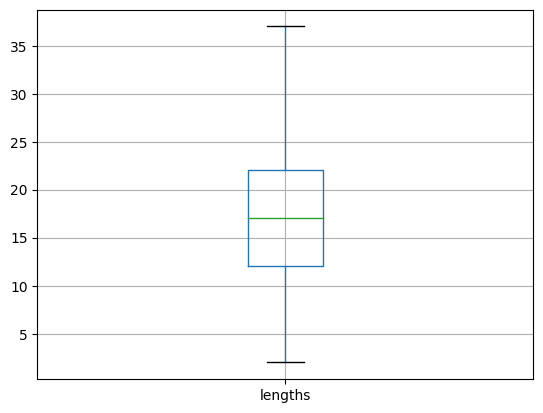

In [ ]:
# Create a boxplot for the 'lengths' column
liar.boxplot(column="lengths", showfliers=False)